### How to create a Gaussian process model based in our simulation example
This notebook is inpired by an introduction in GPyTorch available at: https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html

Import necessary packages

In [2]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

### Set up the training data

In this notebook we employ 400 LHS points from the input space with its corresponding 400 outputs values, that have been computed using the ModelSD.py file.

In [3]:
import pickle
with open('Data/X400.pickle', 'rb') as handle:
    x_labeled = pickle.load(handle)
with open('Data/output400.pickle', 'rb') as handle:
    y_labeled = pickle.load(handle)

y_labeled= y_labeled.astype(float)
y_labeled = torch.from_numpy(y_labeled)
X_labeled = torch.from_numpy(x_labeled)



### Step up the Gaussian process model
For most GP regression models, you will need to construct the following GPyTorch objects:

A GP Model (gpytorch.models.ExactGP) - This handles most of the inference.

A Likelihood (gpytorch.likelihoods.GaussianLikelihood) - This is the most common likelihood used for GP regression. This likelihood assumes homoskedastic noise (all the inputs have the same observational noise).

A Mean - This defines the prior mean of the GP.(gpytorch.means.ConstantMean() is a constant mean, the most common used)

A Kernel - This defines the prior covariance of the GP.(gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) is one of the most common one).

A MultivariateNormal Distribution (gpytorch.distributions.MultivariateNormal) - This is the object used to represent multivariate normal distributions.

In [4]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() #define the mean of the GP
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) #define the covariance of the GP

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood() #define the likelihood of the GP
model = ExactGPModel(X_labeled, y_labeled, likelihood) #creation of the model

### Training the model
Training the Gaussian process means finding the values of the hyperparameter that better fit the training data

The basic training loop is defined by:
1. Put to zero all the parameters gradients
2. Call the model and compute the loss
3. Call backward to the loss to fill the gradients
4. Take a step on the optimizer

In [5]:
# Train the model on the labeled dataset
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1) #select the optimizer
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model) #type of loss employed

for i in range(500):
    optimizer.zero_grad()
    output = model(X_labeled)
    loss = -mll(output, y_labeled) #comput the loss
    loss.backward()
    optimizer.step()

### Make predictions with the model

To make predictions we call the model in eval mode which is the same as computing the posterior distribution of our Gaussian process.
The function likelihood(model(test_x)) gives us the probability distribution over the predicted output value.

In [6]:
with open('Data/X400.2.pickle', 'rb') as handle:
   X_unlabeled = pickle.load(handle)

X_unlabeled = torch.from_numpy(X_unlabeled)

In [7]:
# Use the model to make predictions on the unlabeled dataset
model.eval()
likelihood.eval()
with torch.no_grad():
    pred_dist = likelihood(model(X_unlabeled))

pred_dist

MultivariateNormal(loc: torch.Size([400]))

Our input space is 3 dimensional correspoding with the input parameters: beta_female_travel, beta_student_travel, beta_TRANS_travel.

To visualize it, we choose to plot the third input values, corresponding to the percentage of change in the beta_TRANS_values.
This beta correspod to the variable of wheter or not the person has a public transport monthly pass.

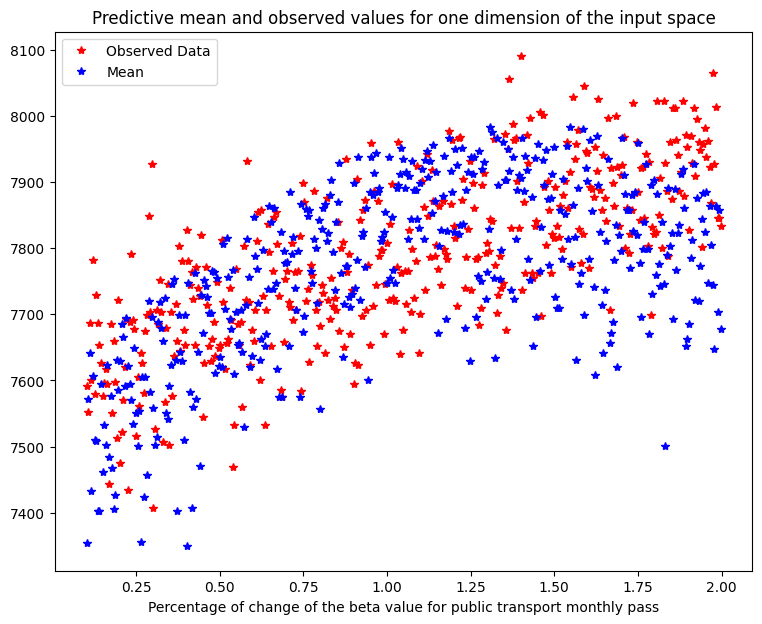

In [9]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(9, 7))
    # Plot training data as black stars
    ax.plot(X_labeled.numpy()[:,2], y_labeled.numpy(), 'r*')
    # Plot predictive means as blue line
    ax.plot(X_unlabeled.numpy()[:,2], pred_dist.mean.numpy(), 'b*')
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title("Predictive mean and observed values for one dimension of the input space")
    ax.set_xlabel("Percentage of change of the beta value for public transport monthly pass")
